<h1><b>인공지능개론 6주차 과제<br></b></h1>
<p>컴퓨터공학과 202136038 조성준</p>


---

<h1><b>Pytorch 회귀(diabetes.csv)<br></b></h1>

---



<h2><b>0. 라이브러리 import</b></h2>

In [15]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

<h2><b>1. 데이터 로딩</b></h2>

In [16]:
# URL
url = "https://raw.githubusercontent.com/MyungKyuYi/AI-class/refs/heads/main/diabetes.csv"

# URL에서 직접 CSV 불러오기
df = pd.read_csv(url)

# 데이터 확인
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [17]:
# 컬렴명 확인
print(df.columns)

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')


<h2><b>2. 결측치 확인</b></h2>

In [18]:
# 결측치 확인
print(df.isnull().sum())
# 확인 결과: 결측치가 확인되지않음

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


<h2><b>3. 레이블 확인(imbalanced data)</b></h2>
<li>타겟 변수의 분포를 확인</li>

,count
BMI,
32.0,13
31.6,12
31.2,12
0.0,11
32.4,10
...,...
49.6,1
24.1,1
41.2,1


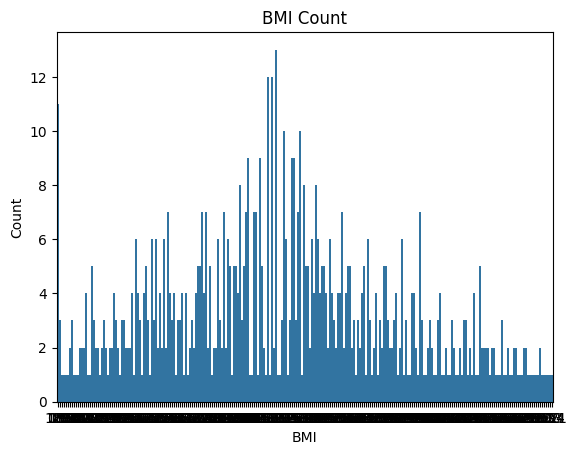

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
# 레이블 갯수 확인 (그래프)
sns.countplot(data=df, x="BMI")
plt.xlabel("BMI")
plt.ylabel("Count")
plt.title("BMI Count")
# 레이블 갯수 확인 (숫자)
df['BMI'].value_counts()

<h2><b>4. 데이터 전처리</b></h2>

In [20]:
from torch.utils.data import Dataset, DataLoader
X = df.drop(columns=["BMI"])
y = df["BMI"].values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 정규화
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Dataset
class BMIDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(BMIDataset(X_train, y_train), batch_size=32, shuffle=True)
val_loader = DataLoader(BMIDataset(X_val, y_val), batch_size=32, shuffle=False)

<h2><b>5. 모델 정의</b></h2>

In [21]:
# 모델 정의
class RegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(X_train.shape[1], 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)

model = RegressionModel()

<h2><b>6. 손실함수 및 옵티마이져 기법 정의</b></h2>

In [22]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

<h2><b>7. 모델 학습 </b></h2>

In [23]:
# 학습
num_epochs = 100
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    for X_batch, y_batch in train_loader:
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)
    train_losses.append(running_loss / len(train_loader.dataset))

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)
    val_losses.append(val_loss / len(val_loader.dataset))

    if (epoch+1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

Epoch 1/100, Train Loss: 1071.7554, Val Loss: 1059.6224
Epoch 10/100, Train Loss: 80.6467, Val Loss: 86.7339
Epoch 20/100, Train Loss: 50.5416, Val Loss: 72.2508
Epoch 30/100, Train Loss: 43.3726, Val Loss: 66.7982
Epoch 40/100, Train Loss: 39.5783, Val Loss: 64.0229
Epoch 50/100, Train Loss: 37.6559, Val Loss: 63.2723
Epoch 60/100, Train Loss: 35.8371, Val Loss: 61.9091
Epoch 70/100, Train Loss: 34.6481, Val Loss: 61.6210
Epoch 80/100, Train Loss: 33.7858, Val Loss: 60.5269
Epoch 90/100, Train Loss: 32.9828, Val Loss: 60.3112
Epoch 100/100, Train Loss: 32.3348, Val Loss: 59.5345


<h2><b>8. 학습곡선 시각화 </b></h2>

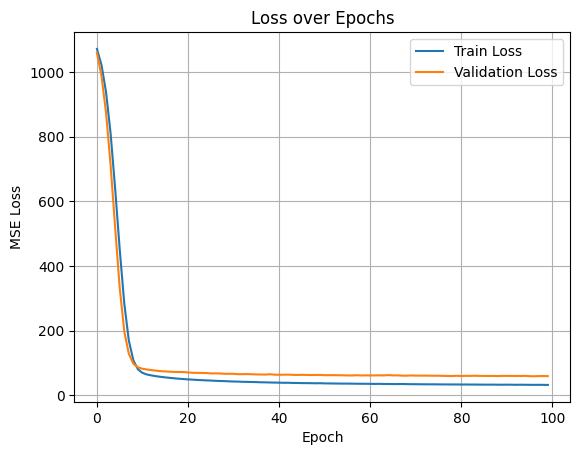

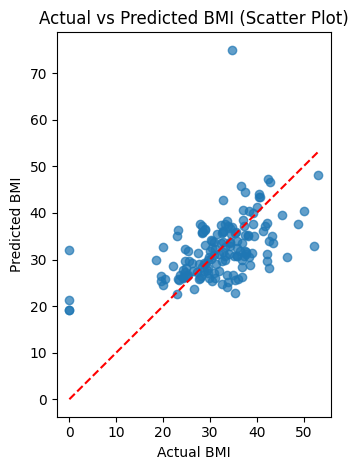

In [32]:
# Loss 시각화
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.subplot(1, 2, 2)
plt.scatter(targets, preds, alpha=0.7)
plt.plot([min(targets), max(targets)], [min(targets), max(targets)], color='red', linestyle='--')
plt.title("Actual vs Predicted BMI (Scatter Plot)")
plt.xlabel("Actual BMI")
plt.ylabel("Predicted BMI")

plt.tight_layout()
plt.show()

<h2><b>9. 모델 평가 </b></h2>

In [33]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

model.eval()
preds, targets = [], []
with torch.no_grad():
    for X_batch, y_batch in val_loader:
        outputs = model(X_batch)
        preds.extend(outputs.numpy().flatten())
        targets.extend(y_batch.numpy().flatten())

mae = mean_absolute_error(targets, preds)
mse = mean_squared_error(targets, preds)
rmse = np.sqrt(mse)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")


MAE: 5.3989
RMSE: 7.7159
